In [1]:
!pip install easyocr
!pip install ultralyticsplus==0.0.24 ultralytics==8.0.23

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 17.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [ ]:
!pip install supervision

## Camera Capture
Using a webcam to capture images for processing on the runtime.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image

filename = take_photo()
print('Saved to {}'.format(filename))
# Show the image which was just taken.
display(Image(filename))

## Cross-output communication

The output of each cell is hosted in a separate sandboxed iframe without direct access to the contents of other cells, but they can create [BroadcastChannel](https://developer.mozilla.org/en-US/docs/Web/API/BroadcastChannel/BroadcastChannel)s to communicate between cells.

In [ ]:
%%javascript
const listenerChannel = new BroadcastChannel('channel');
listenerChannel.onmessage = (msg) => {
  const div = document.createElement('div');
  div.textContent = msg.data;
  document.body.appendChild(div);
};

<IPython.core.display.Javascript object>

This second cell will be in a separate sandboxed iframe.


In [ ]:
%%javascript
const senderChannel = new BroadcastChannel('channel');
senderChannel.postMessage('Hello world!');

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to photo.jpg


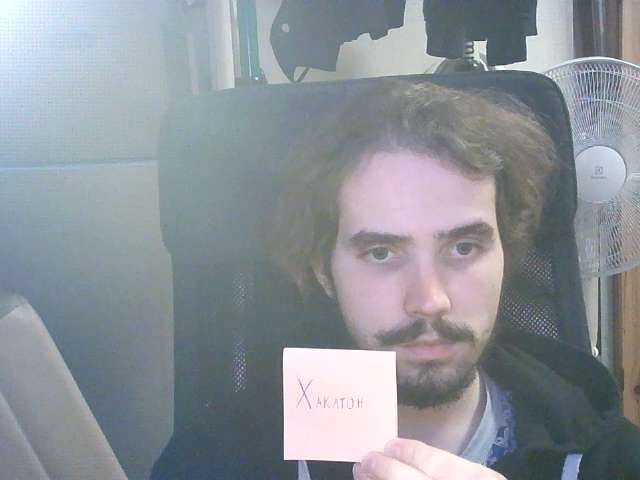

Ultralytics YOLOv8.0.23 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
image 1/1 /content/photo.jpg: 480x640 1 person, 7.7ms
Speed: 0.5ms pre-process, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Ultralytics YOLOv8.0.23 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
image 1/1 /content/photo.jpg: 480x640 1 NO-Hardhat, 10.4ms
Speed: 0.5ms pre-process, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


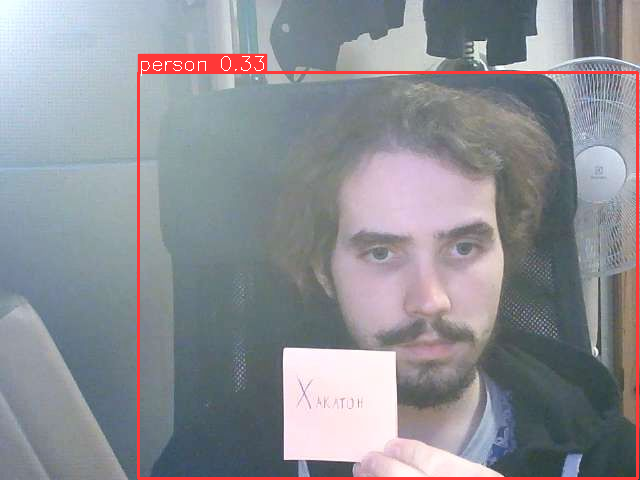

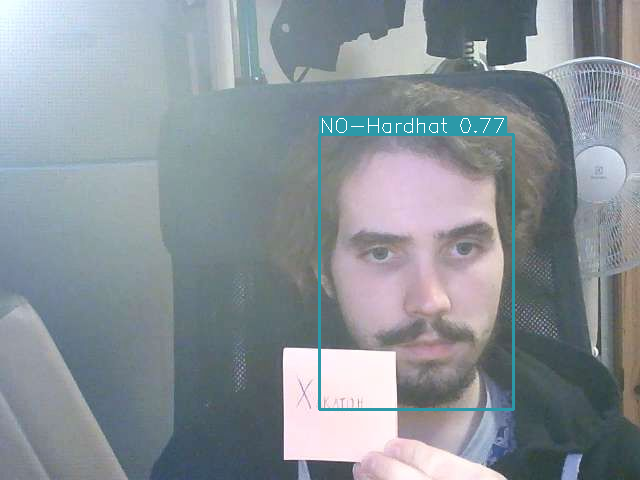

[([[291, 375], [369, 375], [369, 413], [291, 413]],
  'Хчлтш;',
  0.10491230330864955)]

In [ ]:
from ultralytics import YOLO
import easyocr
from ultralyticsplus import YOLO, render_result
from IPython.display import Image
import PIL

filename = take_photo()
print('Saved to {}'.format(filename))
# Show the image which was just taken.
display(Image(filename))

text_reader = easyocr.Reader(['ru'])
base_model = YOLO('yolov8n.pt') # load an official model
hat_model = YOLO('keremberke/yolov8n-hard-hat-detection')


def analyze_image(image_path):

   # Set custom configuration parameters for base_model
    base_model.overrides['classes'] = [0, 10, 14, 15, 16, 24, 25, 26, 27, 28, 34, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 73, 74]
    base_model.overrides['conf'] = 0.25  # NMS confidence threshold
    base_model.overrides['iou'] = 0.45  # NMS IoU threshold

    # Set custom configuration parameters for hat_model
    hat_model.overrides['classes'] = [0]  # Only detect class 0 (hard hat)
    hat_model.overrides['conf'] = 0.25  # NMS confidence threshold
    hat_model.overrides['iou'] = 0.45  # NMS IoU threshold
    hat_model.overrides['agnostic_nms'] = False  # NMS class-agnostic
    hat_model.overrides['max_det'] = 1000  # maximum number of detections per image

    result_text = text_reader.readtext(image_path)
    results_objects = base_model(image_path)  # predict on an image
    results_hats = hat_model.predict(image_path)

    print("Base model results:")
    for result in results_objects:
        print(result.boxes.xyxy)

    print("\nHard hat detection results:")
    for result in results_hats:
        print(result.boxes.xyxy)

    render_hats = render_result(model=hat_model, image=image_path, result=results_hats[0])
    render_hats.show()
     # Analyze the detected classes and recommend a configuration
    detected_classes = set([result.boxes.cls[0] for result in results_objects])
    recommended_config = None
    if detected_classes.issubset({0, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}):
            recommended_config = 3
    elif detected_classes.issubset({0, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67}):
        recommended_config = 2
    elif detected_classes.issubset({0, 10, 14, 15, 16, 24, 25, 26, 27, 28, 34, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 73, 74}):
        recommended_config = 1
    if recommended_config:
        print(f"\nRecommended configuration: {recommended_config}")

    # Recommendations



def set_model_config(config_num=None, classes=None, conf=None, iou=None, max_det=None):
    if config_num == 1:
        base_model.overrides['classes'] = [0, 10, 14, 15, 16, 24, 25, 26, 27, 28, 34, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 73, 74]
        base_model.overrides['conf'] = 0.3
        base_model.overrides['iou'] = 0.5
        hat_model.overrides['classes'] = [0]
        hat_model.overrides['conf'] = 0.3
        hat_model.overrides['iou'] = 0.5
        hat_model.overrides['max_det'] = 500
    elif config_num == 2:
        base_model.overrides['classes'] = [0, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67]
        base_model.overrides['conf'] = 0.4
        base_model.overrides['iou'] = 0.6
        hat_model.overrides['classes'] = [0]
        hat_model.overrides['conf'] = 0.4
        hat_model.overrides['iou'] = 0.6
        hat_model.overrides['max_det'] = 1000
    elif config_num == 3:
        base_model.overrides['classes'] = [0, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
        base_model.overrides['conf'] = 0.3
        base_model.overrides['iou'] = 0.5
        hat_model.overrides['classes'] = [0]
        hat_model.overrides['conf'] = 0.3
        hat_model.overrides['iou'] = 0.5
        hat_model.overrides['max_det'] = 500
    else:
        # Set custom configuration parameters
        base_model.overrides['classes'] = classes
        base_model.overrides['conf'] = conf
        base_model.overrides['iou'] = iou
        hat_model.overrides['classes'] = classes
        hat_model.overrides['conf'] = conf
        hat_model.overrides['iou'] = iou
        hat_model.overrides['max_det'] = max_det


# Set custom configuration parameters for hat_model
base_model.overrides['classes'] = [0] # Only detect class 0 (hard hat)
base_model.overrides['conf'] = 0.25 # NMS confidence threshold
base_model.overrides['iou'] = 0.45 # NMS IoU threshold

# Set custom configuration parameters for hat_model
hat_model.overrides['classes'] = [0, 1]
hat_model.overrides['conf'] = 0.25 # NMS confidence threshold
hat_model.overrides['iou'] = 0.45 # NMS IoU threshold
hat_model.overrides['agnostic_nms'] = False # NMS class-agnostic
hat_model.overrides['max_det'] = 1000 # maximum number of detections per image

image = '/content/photo.jpg'
result_text = text_reader.readtext(image)
results_objects = base_model(image) # predict on an image
results_hats = hat_model.predict(image)

# Create Detections object from YOLOv8 predictions
boxes = results_objects[0].boxes.xyxy
scores = results_objects[0].boxes.conf
class_ids = results_objects[0].boxes.cls

# Add bounding boxes and labels to the image
image_with_boxes_objects = render_result(model=base_model, image=image, result=results_objects[0])

display(image_with_boxes_objects)

boxes_hats = results_hats[0].boxes.xyxy
scores_hats = results_hats[0].boxes.conf
class_ids_hats = results_hats[0].boxes.cls
image_with_boxes_hats = render_result(model=hat_model, image=image, result=results_hats[0])

display(image_with_boxes_hats)
result_text